In [102]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import xeofs as xe
import numpy as np
import seaborn as sns
from scipy.stats import binned_statistic_2d
import matplotlib.colors as colors
from src.configs import Configs

In [2]:
REGION_NAME = 'tropical_nw_pacific'
configs = Configs(REGION_NAME)

In [3]:
era5_pcs = xr.open_dataarray(f'{configs.get_project_root_dir()}/data-output/era5.pcs.{REGION_NAME}.massflux.2deg.nc')
gsam_pcs = xr.open_dataarray(f'{configs.get_project_root_dir()}/data-output/gsam.pcs_era5_levels.{REGION_NAME}.massflux.50pix.nc')

In [4]:
def _compute_mean_pc_tendency(pcs, method='centered', normed=True):
    if normed:
        pcs /= pcs.std(('lat', 'lon', 'time'))
    match method:
        case 'centered':
            delta_pc = pcs.isel(time=slice(2, None)).data - pcs.isel(time=slice(None, -2)).data
            delta_pc = pcs.isel(time=slice(1, -1)).copy(data=delta_pc)
            delta_t = 6
        case 'forward': 
            delta_pc = pcs.isel(time=slice(1, None)).data - pcs.isel(time=slice(None, -1)).data
            delta_pc = pcs.isel(time=slice(None, -1)).copy(data=delta_pc)
            delta_t = 3
        case 'backward':
            delta_pc = pcs.isel(time=slice(1, None)).data - pcs.isel(time=slice(None, -1)).data
            delta_pc = pcs.isel(time=slice(1, None)).copy(data=delta_pc)
            delta_t = 3
        
    return(delta_pc/delta_t)

def _bin_stat_by_pcs(pcs, data, pc1_bins, pc2_bins, stat):
    x = pcs.sel(mode=1).data.ravel()
    y = pcs.sel(mode=2).data.ravel()
    out = binned_statistic_2d(y, x, data.data.ravel(), stat, bins=[pc2_bins, pc1_bins]).statistic
    return(out)

# Mean evolution as quiver plots

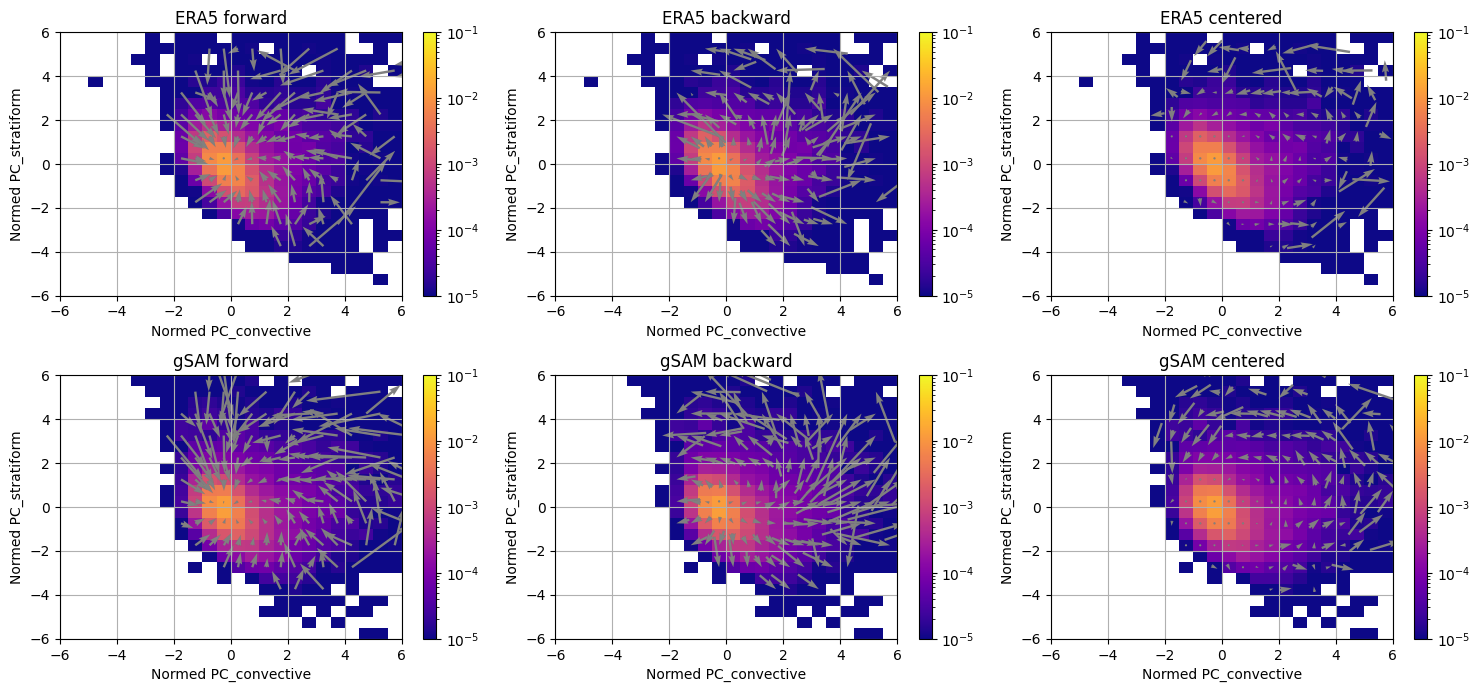

In [130]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 7))

pc1_bins = np.arange(-10, 10, 0.5)
pc2_bins = np.arange(-10, 10, 0.5)
midpoint_pc1_bins = (pc1_bins[1:]+pc1_bins[:-1])/2
midpoint_pc2_bins = (pc2_bins[1:]+pc2_bins[:-1])/2
xmesh, ymesh = np.meshgrid(midpoint_pc1_bins, midpoint_pc2_bins)
normed = True
arrow_space = 2
obs_cutoff=2
for axi, ax in enumerate(axs.ravel()):
    i, j = np.unravel_index(axi, axs.shape)
    pcs = [era5_pcs, gsam_pcs][i]
    dataset = ['ERA5', 'gSAM'][i]
    method = ['forward', 'backward', 'centered'][j]
    pivot = ['tail', 'tip', 'mid'][j]
    hist = stats.binned_statistic_2d(
                pcs.sel(mode=2).data.ravel(),
                pcs.sel(mode=1).data.ravel(),
                delta_pcs.sel(mode=mode).data.ravel(),
                statistic='count', 
                bins=[pc2_bins, pc1_bins]
            ).statistic/delta_pcs.size
    delta_pcs =  _compute_mean_pc_tendency(pcs, method, normed)
    pcs = pcs.sel(time=delta_pcs.time)
    bin_mean_data = dict()
    for mode in [1,2]:
        bin_mean_delta_pc= stats.binned_statistic_2d(
            pcs.sel(mode=2).data.ravel(),
            pcs.sel(mode=1).data.ravel(),
            delta_pcs.sel(mode=mode).data.ravel(),
            statistic=lambda x: np.nanmean(x) if x.size>obs_cutoff else np.nan, 
            bins=[pc2_bins, pc1_bins]
        ).statistic
        bin_mean_data[mode] = bin_mean_delta_pc
       
    c = ax.pcolormesh(xmesh, ymesh, hist, norm=colors.LogNorm(vmin=1e-5, vmax=1e-1), cmap=plt.cm.plasma.copy())

    samp = (slice(None, None, arrow_space), slice(None, None, arrow_space-1))
    ax.quiver(xmesh[samp], ymesh[samp], bin_mean_data[1][samp], bin_mean_data[2][samp], angles='xy', pivot=pivot, scale=8, width=0.007, headwidth=3, lw=0.009, edgecolor='black', facecolor='grey')

    ax.set_title(f'{dataset} {method}')
    ax.set_xlabel(rf'Normed PC_convective')
    ax.set_ylabel(rf'Normed PC_stratiform')
    ax.grid()
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    fig.colorbar(c)
fig.tight_layout(pad=1)

plt.savefig('../plotting-figures/mean_pc_evolution_cartesian.pdf', format='pdf');

# Transition Matricies

In [5]:
def _compute_theta(pcs):
    theta = np.arctan2(pcs.sel(mode=2), pcs.sel(mode=1))
    return(theta)

def _compute_r(pcs):
    r2 = pcs.sel(mode=2)**2 + pcs.sel(mode=1)**2
    return(r2**1/2)
    
def _compute_phase_number(theta):
    p = np.floor(np.mod((np.array(theta)+(np.pi/8))/(np.pi/4) + 4, 8))+1
    return(p)

def _compute_delta_theta(theta, method='centered'):
    ## Use the same method as the pc tendency
    delta = _compute_mean_pc_tendency(theta, method, normed=False)
    delta = np.mod(delta + np.pi, 2*np.pi) - np.pi
    return(delta)

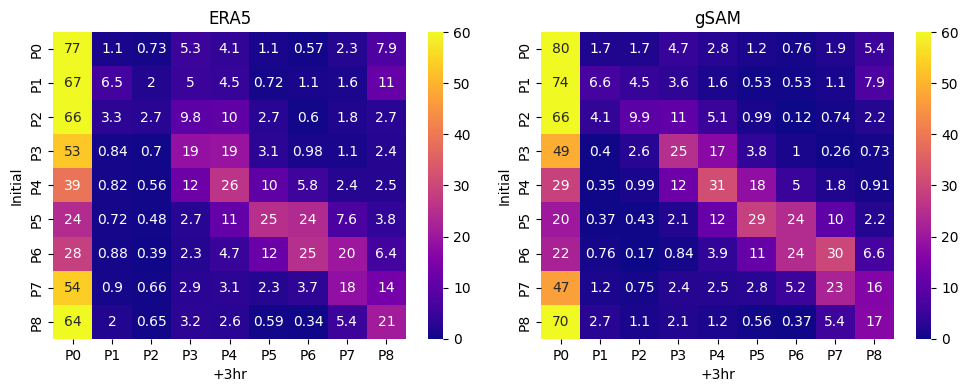

In [126]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
for pci, pcs in enumerate([era5_pcs, gsam_pcs]):
    pcs = pcs/pcs.std(('lat', 'lon', 'time'))
    theta = _compute_theta(pcs)
    phase = _compute_phase_number(theta)
    r = _compute_r(pcs)
    phase[r<=0.5] = 0
    
    start_phase = phase[:-1, :, :]
    end_phase = phase[1:, :, :]
    transition_matrix = np.full((9,9), fill_value=np.nan)
    for i in range(0, 9):
        for j in range(0, 9):
            transition_matrix[i,j] = sum((start_phase.ravel()==i)&(end_phase.ravel()==j))

    row_sums = transition_matrix.sum(axis=1) + 1e-25
    transition_matrix = transition_matrix / row_sums[:, np.newaxis]
    sns.heatmap(ax=axs[pci], 
            data=100*transition_matrix, annot=True,
            cmap=plt.cm.plasma,
            norm=colors.Normalize(vmin=0, vmax=60), 
            xticklabels=[f'P{i}' for i in range(0,9)],
            yticklabels =[f'P{i}' for i in range(0,9)])

    axs[pci].set_title(['ERA5', 'gSAM'][pci])
    axs[pci].set_xlabel('+3hr')
    axs[pci].set_ylabel('Initial')

fig.tight_layout(pad=1)

plt.savefig('../plotting-figures/transition_matrix_forward.pdf', format='pdf')

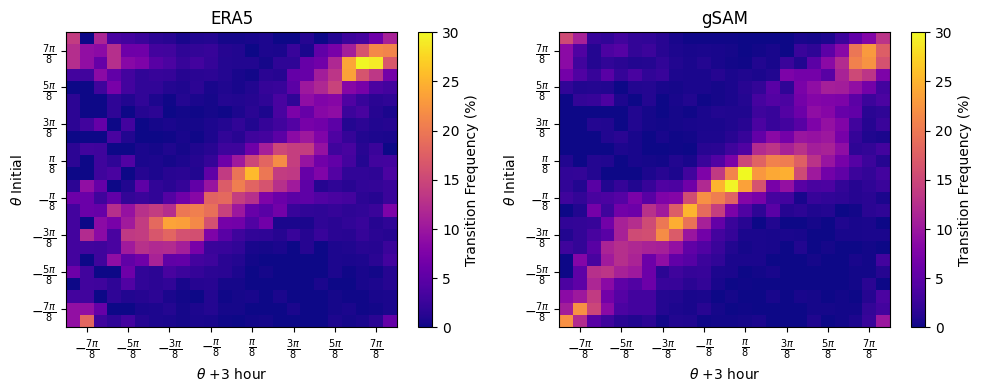

In [124]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
xbins = np.linspace(-np.pi, np.pi, 25)
ybins = np.linspace(-np.pi, np.pi, 25)
ybins_mp = (ybins[1:]+ybins[:-1])/2
xbins_mp = (xbins[1:]+xbins[:-1])/2
xmesh, ymesh = np.meshgrid(xbins_mp, ybins_mp)

for i, pcs in enumerate([era5_pcs, gsam_pcs]):
    r = _compute_r(pcs/pcs.std(('lat', 'lon', 'time')))
    
    theta =  _compute_theta(pcs).where(r>0.5)
    theta_start = theta.isel(time=slice(None, -1)).data.ravel()
    theta_end   = theta.isel(time=slice(1, None)).data.ravel()
    assert(theta_start.size==theta_end.size)

    trans_freq = binned_statistic_2d(theta_end, theta_start, None, statistic='count', bins=[xbins, ybins]).statistic
    row_sums = trans_freq.sum(axis=1) + 1e-25
    trans_freq = 100*trans_freq / row_sums[:, np.newaxis]
    ax = axs[i]
    # Transpose matrix for plotting
    cmap = plt.cm.plasma.copy()
    c = ax.pcolormesh(xmesh, ymesh, trans_freq.T, norm=colors.Normalize(vmin=0, vmax=30), cmap=cmap)

    ax.set_xlabel(r'$\theta$ +3 hour')
    ax.set_ylabel(r'$\theta$ Initial')
    ax.set_title(['ERA5', 'gSAM'][i])

    ticks = [-7*np.pi/8, -5*np.pi/8, -3*np.pi/8, -np.pi/8, np.pi/8, 3*np.pi/8, 5*np.pi/8, 7*np.pi/8]
    
    # Define the labels using LaTeX (hard-coded)
    tick_labels = [
        r"$-\frac{7\pi}{8}$", r"$-\frac{5\pi}{8}$", r"$-\frac{3\pi}{8}$", r"$-\frac{\pi}{8}$",
        r"$\frac{\pi}{8}$", r"$\frac{3\pi}{8}$", r"$\frac{5\pi}{8}$", r"$\frac{7\pi}{8}$"
    ]
    
    # Set the x and y ticks and labels
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label('Transition Frequency (%)')

fig.tight_layout(pad=1)